# Paper 1: Deep Unsupervised Learning using Nonequilibrium Thermodynamics

## Overview

For each epoch:
* Create swissroll data
* Calculate loss. Call get_loss on diffusion model
  * Create a random time step $t$
  * Forward process. Add noise to the data sample depending on $t$, receive $x_t$
  * Reverse process, receive $x_{t-1}$
    * Let MLP predict $\mu$, $\sigma$ from $x_t$ and $t$ that produce $x_{t-1}$
  * Calculate loss
* Backpropagation, update weights of the MLP

## Implementation

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from tqdm import tqdm

In [2]:
def sample_batch(batch_size, device='cpu'):
    data, _ = make_swiss_roll(batch_size)
    # Make data similar to the paper
    data = data[:, [2, 0]] / 10
    data = data * np.array([1, -1])
    return torch.from_numpy(data).to(device)

In [3]:
class MLP(nn.Module):
    """
    Train a FC MLP to predict the mean and std values from a given data x and time step t.
    """
    
    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()
        
        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim),
                                          nn.ReLU(),)
        
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                                         nn.ReLU(),
                                                         nn.Linear(hidden_dim, data_dim * 2),) for t in range(N)])
        
    def forward(self, x, t):
        
        h = self.network_head(x) # [batch_size, hidden_dim]
        tmp = self.network_tail[t](h) # [batch_size, data_dim * 2]
        mu, h = torch.chunk(tmp, 2, dim=1)
        # h is not bounded. 
        var = torch.exp(h)  # make it >0
        std = torch.sqrt(var)
        
        return mu, std
    

In [4]:
class DiffusionModel():
    
    def __init__(self, T, model: nn.Module, device, dim=2):
        # Scale the data between this range
        self.betas = (torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5).to(device)
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)
        
        self.T = T
        self.model = model  # f_mu, f_sig predictor
        self.dim = dim
        
    def forward_process(self, x0, t): 
        """
        :param t: Number of diffusion steps
        """
        
        assert t > 0, 't should be greater than 0'
        assert self.T <= self.T, f't should be lower or equal than {self.T}'
        
        t = t - 1 # Because we start indexing at 0
        
        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)
        xt = mu + epsilon * std # data ~ N(mu, std)
        
        
        std_q = torch.sqrt((1 - self.alphas_bar[t-1])/ (1 - self.alphas_bar[t]) * self.betas[t])
        m1 = torch.sqrt(self.alphas_bar[t-1]) * self.betas[t] / (1 - self.alphas_bar[t])
        m2 = torch.sqrt(self.alphas[t]) * (1 - self.alphas_bar[t-1]) / (1 - self.alphas_bar[t])
        mu_q = m1 * x0 + m2 * xt
        
        return mu_q, std_q, xt
    
    def reverse_process(self, xt, t): 
        """
        :param t: Number of diffusion steps
        """
        
        assert t > 0, 't should be greater than 0'
        assert self.T <= self.T, f't should be lower or equal than {self.T}'
        
        t = t - 1 # Because we start indexing at 0
        
        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(xt)
        # Reparamitrazion trick: x0 ~ N(mu, std)
        return mu, std, mu + epsilon * std # data ~ N(mu, std)
    
    
    def sample(self, batch_size, device):
        
        noise = torch.randn((batch_size, self.dim)).to(device)
        x = noise
        
        samples = [x]
        for t in range(self.T, 0, -1):
            
            if not (t == 1):
                _, _, x = self.reverse_process(x, t)
            
            samples.append(x)
            
        return samples[::-1]
    
    
    def get_loss(self, x0):
        """
        :param x0: batch [batch_size, self.dim]
        """
        
        t = torch.randint(2, 40+1, (1,))
        mu_q, sigma_q, xt = self.forward_process(x0, t)
                
        mu_p, sigma_p, xt_minus1 = self.reverse_process(xt.float(), t)
        
        KL = torch.log(sigma_p) - torch.log(sigma_q) + (
            sigma_q**2 + (mu_q - mu_p)**2) / (2 * sigma_p**2)
        K = - KL.mean() # Should be maximized
        loss = - K # Should be minimized
        
        return loss

In [5]:
def plot(model, file_name, device):

    fontsize = 14
    fig = plt.figure(figsize=(10, 6))

    N = 5_000
    x0 = sample_batch(N).to(device)
    samples = model.sample(N, device=device)

    data = [x0.cpu(), model.forward_process(x0, 20)[-1].cpu(), model.forward_process(x0, 40)[-1].cpu()]
    for i in range(3):

        plt.subplot(2, 3, 1+i)
        plt.scatter(data[i][:, 0].data.numpy(), data[i][:, 1].data.numpy(), alpha=0.1, s=1)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')

        if i == 0: plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$', fontsize=fontsize)
        if i == 0: plt.title(r'$t=0$', fontsize=fontsize)
        if i == 1: plt.title(r'$t=\frac{T}{2}$', fontsize=fontsize)
        if i == 2: plt.title(r'$t=T$', fontsize=fontsize)

    time_steps = [0, 20, 40]
    for i in range(3):

        plt.subplot(2, 3, 4+i)
        plt.scatter(samples[time_steps[i]][:, 0].data.cpu().numpy(), samples[time_steps[i]][:, 1].data.cpu().numpy(), 
                    alpha=0.1, c='r', s=1)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')

        if i == 0: plt.ylabel(r'$p(\mathbf{x}^{(0..T)})$', fontsize=fontsize)

    plt.savefig(file_name, bbox_inches='tight')
    plt.close()

In [6]:
def train(diffusion_model, optimizer, batch_size, nb_epochs, device):
    
    training_loss = []
    for epoch in tqdm(range(nb_epochs)):
        x0 = sample_batch(batch_size, device)
        loss = diffusion_model.get_loss(x0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss.append(loss.item())
        
        if epoch % 10_000 == 0:
            plt.plot(training_loss)
            plt.savefig(f'figs/training_loss_epoch_{epoch}.png')
            plt.close()
            
            plot(diffusion_model, f'figs/training_epoch_{epoch}.png', device)
        
    return training_loss

device = 'cuda'
mlp_model = MLP(hidden_dim=128).to(device)
model = DiffusionModel(40, mlp_model, device)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-4)

train(model, optimizer, 64_000, 300_000, device)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [1:25:27<00:00, 58.51it/s]


[2.354858419641144,
 1.0983391861883356,
 6.032204178000533,
 4.059725313899126,
 2.031261280818772,
 1.0955429066226439,
 2.7008346319959675,
 5.840659581616132,
 2.029052720493064,
 1.1200517885180326,
 4.697990547544666,
 1.1757846880209648,
 1.099955035358981,
 6.029830051341934,
 5.69433738191039,
 3.7139480266196205,
 1.1144565050922728,
 1.11486422339225,
 2.026850557927544,
 6.209966419814196,
 5.4875664540130495,
 5.2175379292624875,
 1.5131696920670148,
 1.1034920144934823,
 1.1116412867115568,
 6.330282907090023,
 5.977492524038711,
 2.3500268978083523,
 1.3130611262552156,
 1.102114007910233,
 3.0204554114573603,
 1.1135280034749861,
 6.0978686063887935,
 3.7106375529992537,
 2.3474492029694614,
 1.09121891045816,
 5.976947100979986,
 4.69608785062934,
 1.1117744062509947,
 1.511004105452532,
 4.952470220279325,
 5.215781345516175,
 3.708329805607719,
 5.8380033504714035,
 1.1026032233149472,
 1.7155407450945372,
 5.835828132794333,
 5.931322917748963,
 1.128830512129604,
 

## Inference

In [18]:
inference_samples = model.sample(batch_size=64_000, device=device)

In [19]:
inf_samples = [x.cpu().data.numpy() for x in inference_samples]

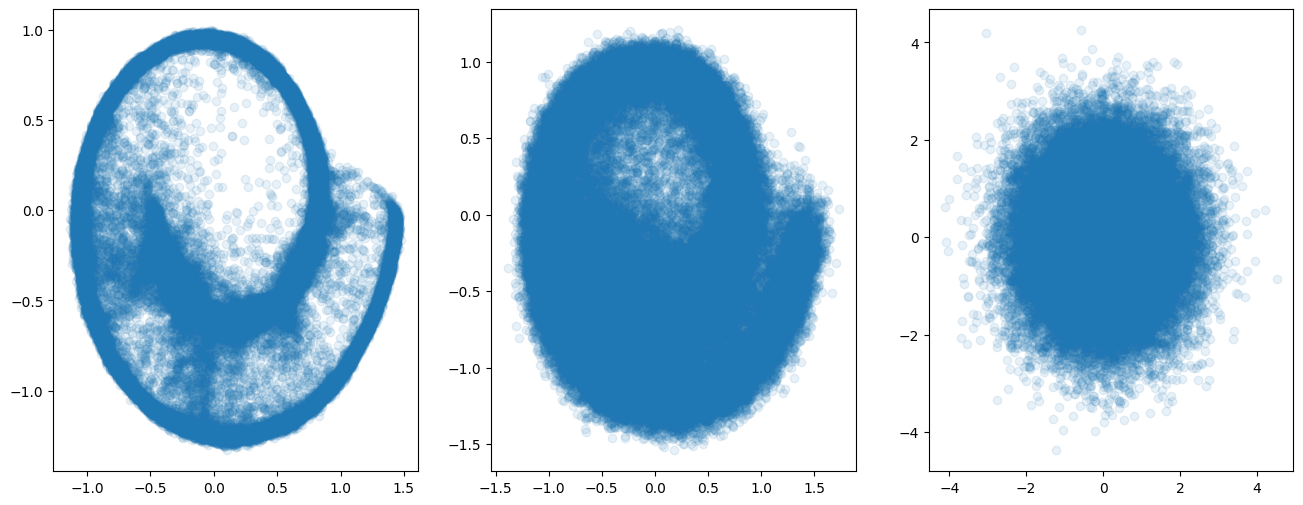

In [20]:
fig, axs = plt.subplots(1,3, figsize=(16,6))

axs[0].scatter(inf_samples[0][:,0], inf_samples[0][:,1], alpha=0.1)
axs[1].scatter(inf_samples[20][:,0], inf_samples[20][:,1], alpha=0.1)
axs[2].scatter(inf_samples[40][:,0], inf_samples[40][:,1], alpha=0.1)